In [1]:
import pandas as pd
from pprint import pprint
from pathlib import Path
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import mplhep as hep
import datetime
hep.style.use('CMS')

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, sys

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'TestBeam')))
print(path2add)

if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from beamtest_analysis_helper import plot_BL_and_NW

path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, 'SEU')))
print(path2add)

if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from SEUhelper import plotVRefPower,plotBoardPower,plotWSPower

/home/daq/ETROC2/ETROC-Analysis/TestBeam
/home/daq/ETROC2/ETROC-Analysis/SEU


## Load Run Info

In [3]:
base_directory = Path("/media/daq/X9/BelgiumJune2024")
output_dir = base_directory/"AnalysisOutput"
output_dir.mkdir(exist_ok=True)
# runs = [3,4,5,6,9,10,11,13]
runs = ["0010","0011","0012","0013","0014","0015","0016","0017","0018"]
config_compare_dir = output_dir/"I2CConfiguration"
# config_compare_dir = output_dir/f"I2CConfiguration_Run{runs[0]}"
config_compare_dir.mkdir(exist_ok=True)

chip_names = [
    "ET2p01_Bare_7", # Ch0
]

config_directory = Path("/media/daq/X9/BelgiumJune2024/ETROC-Data/BelgiumJune2024/ChipConfig")
list_of_all_files = [f for f in os.listdir(config_directory) if os.path.isfile(os.path.join(config_directory,f))]
# pprint(lisat_of_all_files)
run_info = []
for run in runs:
    start_times = []
    stop_times  = []

    for chip_name in chip_names:

        for f in list_of_all_files: 
            
            list_of_words = f.split('_')
            if(list_of_words[-1].split(".")[0]!=run):continue
            read_chip_name = "_".join(list_of_words[1:4])
            if(read_chip_name!=chip_name): continue
            time_string = list_of_words[0].split("T")
            config_time = datetime.datetime.fromisoformat("T".join([time_string[0],time_string[1].replace("-", ":")]))
            if(list_of_words[4]=="PreRun"):
                start_times += [config_time]
            elif(list_of_words[4]=="PostRun"):
                stop_times+= [config_time]
    run_info += [
        {
            "name": f"Run_{run}",
            "extra_begin": start_times[-1],
            "start": start_times[-1],
            "stop": stop_times[0] - datetime.timedelta(minutes=1, seconds=40),
            "boards": chip_names,
            "board_channels": [0],
            "pre_config_times": start_times,
            "post_config_times": stop_times,
            "config_before": True,
            "fluence": 0.0,
        }
    
    ]

test_run_info =  run_info  
start_time = datetime.datetime(2024, 5, 25, 9, 0, 0)
end_time = datetime.datetime(2024, 5, 25, 23, 0, 0)     

In [4]:
# pprint(run_info)

## Baseline plots

In [5]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/BelgiumJune2024/BaselineHistory.sqlite')

baseline_df = pd.read_sql_query("SELECT * from baselines", con)

baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
baseline_df['timestamp'] = baseline_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
baseline_df['timestamp'] = pd.to_datetime(baseline_df['timestamp'])

In [6]:
baseline_df.tail()

,col,row,baseline,noise_width,timestamp,chip_name
2063,15,15,381.0,3.0,2024-06-25 16:03:25,ET2p01_Bare_7
2064,8,0,384.0,3.0,2024-06-25 16:34:00,ET2p01_Bare_7
2065,2,0,371.0,3.0,2024-06-25 16:34:01,ET2p01_Bare_7
2066,8,2,374.0,4.0,2024-06-25 16:34:01,ET2p01_Bare_7
2067,2,2,367.0,4.0,2024-06-25 16:34:02,ET2p01_Bare_7


In [7]:
### Add board names in the dictionary

config_dict = {
    'ET2p01_Bare_7': {
        'plot_title': 'ETROC 2.01 Bare Board 7',
        'chip_type': 'T',
        'channel': 0,
    },
}

### Baseline over time

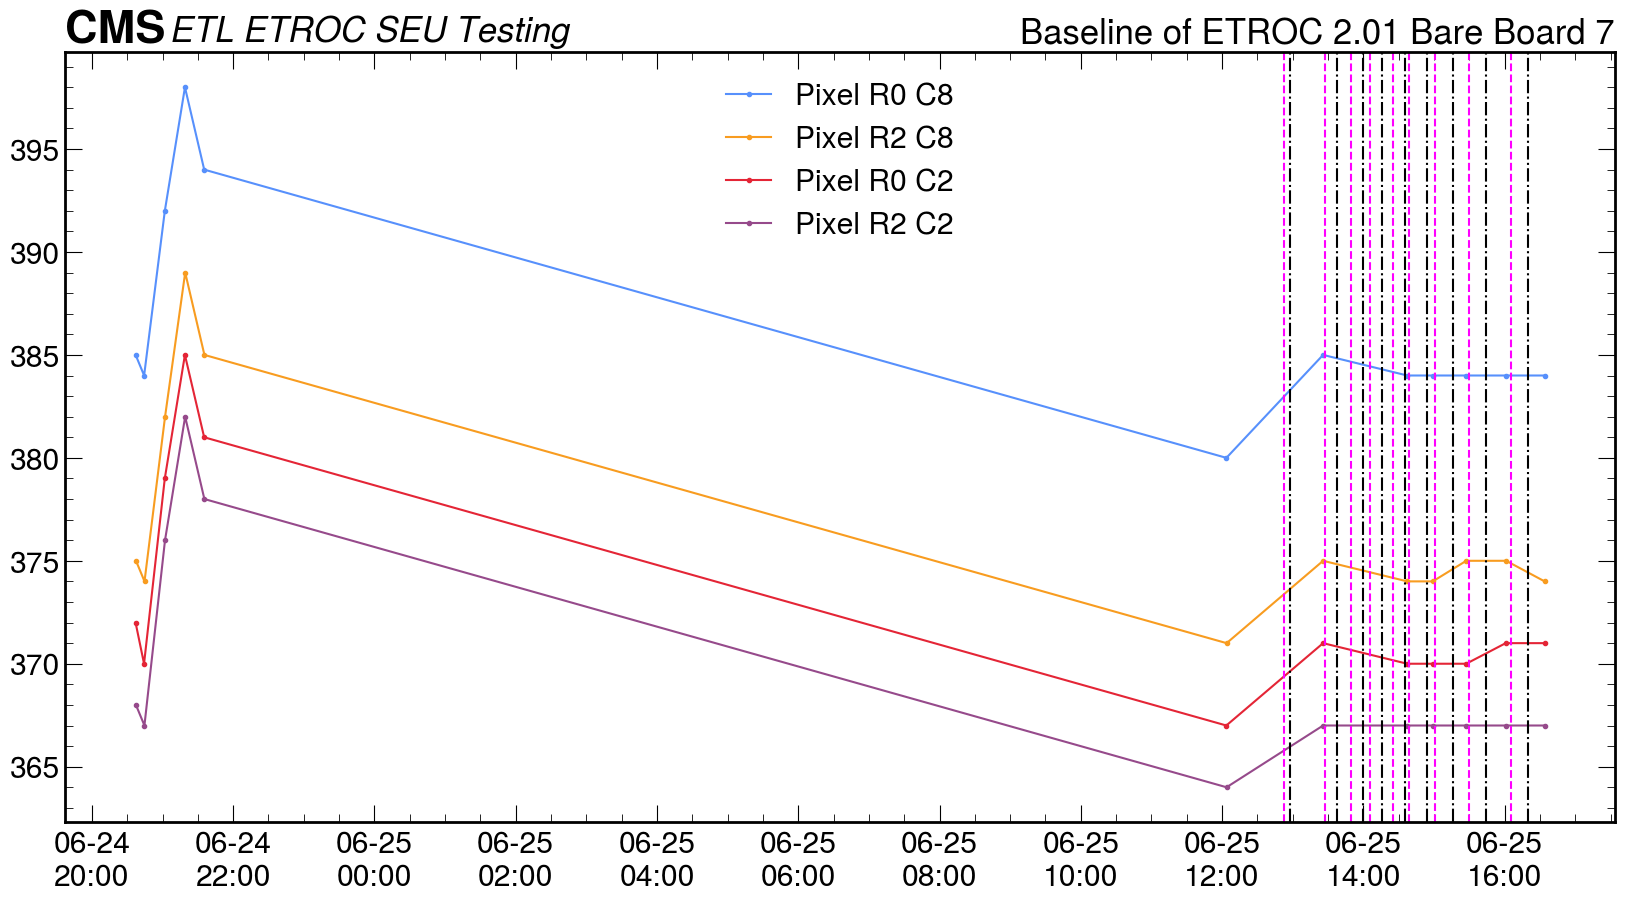

In [8]:
p_col=[8,8,2,2]
p_row=[0,2,0,2]
pixel_plot_list = list(zip(p_row,p_col))

draw_dates = True
cut_time = pd.to_datetime('2024-06-24 20:30:00')

for iboard in baseline_df['chip_name'].unique():
    fig, ax = plt.subplots(figsize=(20, 10))
    hep.cms.text(loc=0, ax=ax, text="ETL ETROC SEU Testing", fontsize=25)
    ax.set_title(f'Baseline of {config_dict[iboard]["plot_title"]}', size=17, loc="right", fontsize=25)
    date_form = mdates.DateFormatter("%m-%d\n%H:%M")
    ax.xaxis.set_major_formatter(date_form)
    for row,col in pixel_plot_list:
        interest_df = baseline_df.loc[baseline_df['chip_name']==iboard]
        tmp_df = interest_df.loc[(interest_df['col']==col) & (interest_df['row']==row)].reset_index(drop=True)
        tmp_df = tmp_df.loc[tmp_df['timestamp'] > cut_time]
        ax.plot(tmp_df['timestamp'], tmp_df['baseline'], label=f'Pixel R{row} C{col}', marker='.')

    if draw_dates:
        for run_dict in run_info:
            if(run_dict['start'] >= cut_time):
                ax.axvline(x=run_dict['start'], color='magenta', linestyle='dashed')
                ax.axvline(x=run_dict['stop'], color='black', linestyle='dashdot')
    # ax.set_xlim(left=cut_time)
    ax.legend()

## Temperature

In [9]:
con = sqlite3.connect('/home/daq/ETROC2/ETROC-History/BelgiumJune2024/ADCHistory.sqlite')

adc_df = pd.read_sql_query("SELECT * from adc", con)

In [10]:
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
adc_df['timestamp'] = adc_df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
adc_df['timestamp'] = pd.to_datetime(adc_df['timestamp'])

In [11]:
adc_df.tail()

,timestamp,ADC,channel,voltage,vref,calibrated,calibrated_units
31621,2024-06-25 17:04:14,823,8,0.502442,2.5,26.507159,C
31622,2024-06-25 17:04:20,890,0,0.543346,2.5,NaN,None
31623,2024-06-25 17:04:20,824,8,0.503053,2.5,26.883949,C
31624,2024-06-25 17:04:25,891,0,0.543956,2.5,NaN,None
31625,2024-06-25 17:04:25,824,8,0.503053,2.5,26.883949,C


(19898.916666666668, 19899.758192708334)

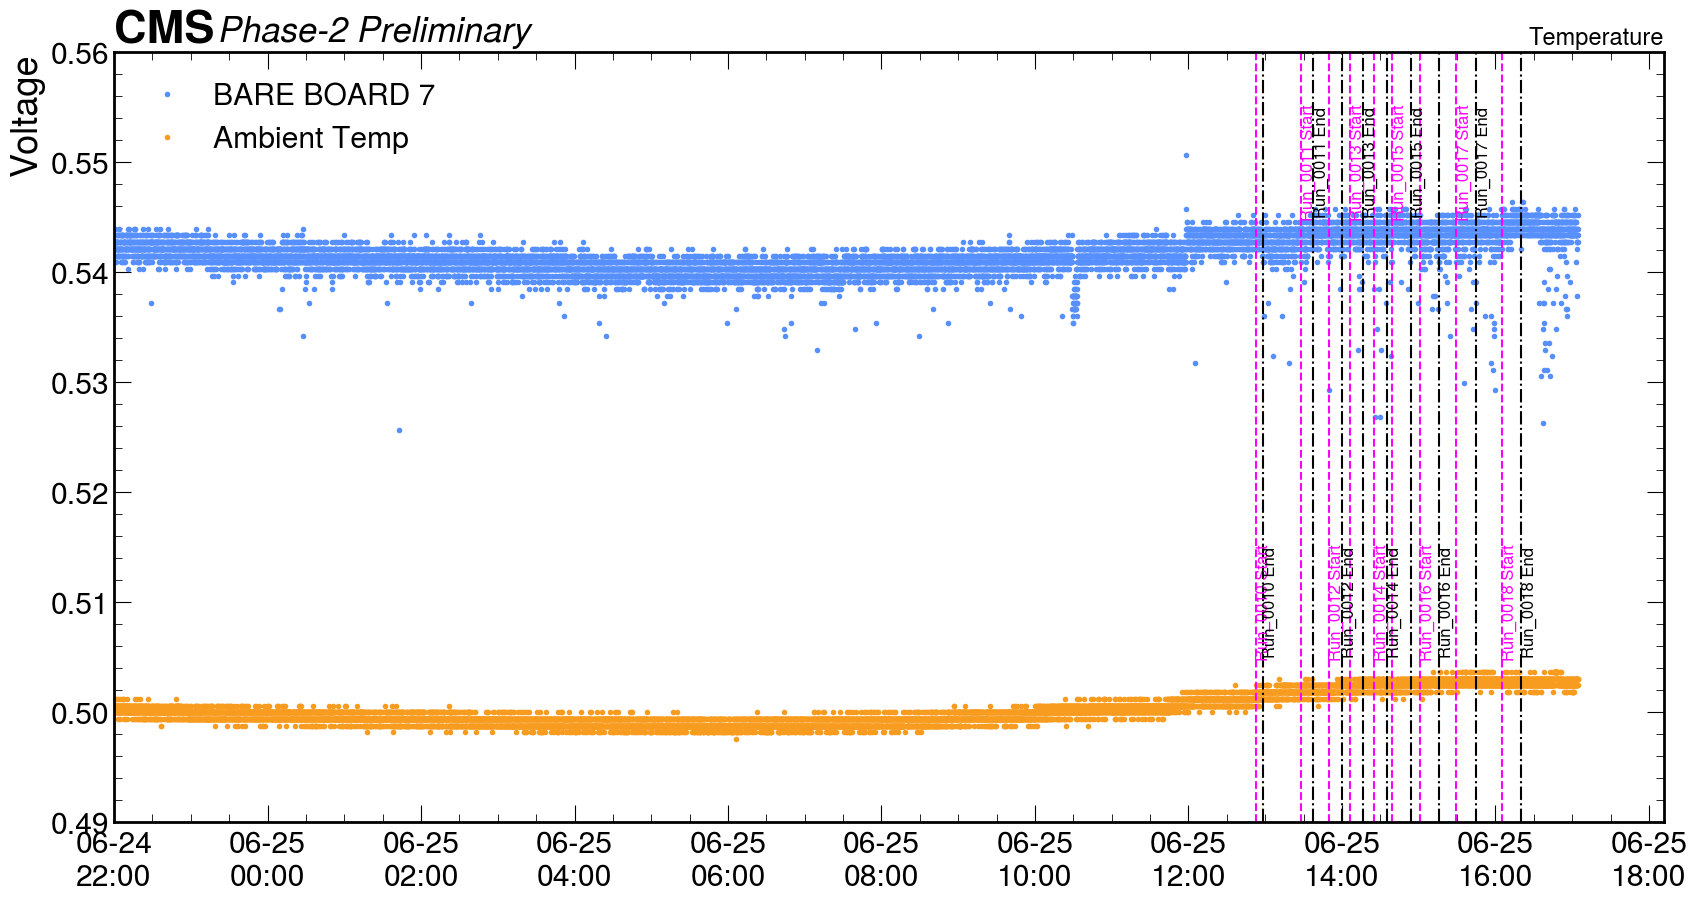

In [12]:
names = ['BARE BOARD 7', 'Ambient Temp']
cut_time = pd.to_datetime('2024-06-24 22:00:00')

fig, ax = plt.subplots(figsize=(20, 10))
hep.cms.text(loc=0, ax=ax, text="Phase-2 Preliminary", fontsize=25)
ax.set_title('Temperature', size=17, loc="right")
date_form = mdates.DateFormatter("%m-%d\n%H:%M")
ax.xaxis.set_major_formatter(date_form)

for idx, iboard in enumerate(sorted(adc_df['channel'].unique())):
    tmp_df = adc_df.loc[adc_df['channel']==iboard]
    ax.plot(tmp_df['timestamp'], tmp_df['voltage'], label=f'{names[idx]}', marker=".", ls="")

text_y = [0.51, 0.55]
if draw_dates:
        for index,run_dict in enumerate(run_info):
            if index%2 == 0:
                yval = text_y[0]
            else:
                yval = text_y[1]
            if(run_dict['start'] >= cut_time):
                ax.axvline(x=run_dict['start'], color='magenta', linestyle='dashed')
                ax.text(x=(run_dict['start'] ), y=yval, s=f"{run_dict['name']} Start", rotation=90, va='center', fontsize=12, color='magenta')
                ax.axvline(x=run_dict['stop'], color='black', linestyle='dashdot')
                ax.text(x=(run_dict['stop'] ), y=yval, s=f"{run_dict['name']} End", rotation=90, va='center', fontsize=12)
                
ax.legend(loc='best')
ax.set_ylabel('Voltage')
plt.ylim(bottom=0.49, top=.56)
plt.xlim(left=cut_time)

# Power Monitoring

In [13]:
start_time = datetime.datetime(2024, 6, 25, 12, 30, 0)
end_time = datetime.datetime(2024, 6, 25, 19, 0, 0)

power_file = Path("/home/daq/ETROC2/ETROC-History/BelgiumJune2024/PowerHistory_v2.sqlite")

power_connections = {
    "ET2.01 Bare Board 7": {
        "Analog": "Analog",
        "Digital": "Digital",
    },
}

In [14]:
power_directory = output_dir/"PowerPlots"
power_directory.mkdir(exist_ok=True)

with sqlite3.connect(power_file) as sqlite3_connection:
    data_df = pd.read_sql('SELECT * FROM power_v2', sqlite3_connection, index_col=None)
    data_df['Time'] = pd.to_datetime(data_df['timestamp'], format='mixed')

    # Remove data that is outside the range of the campaign
    data_df = data_df.loc[data_df['Time'] >= start_time]
    data_df = data_df.loc[data_df['Time'] <= end_time].copy()

    data_df['V'] = data_df['V'].astype(float)
    data_df['I'] = data_df['I'].astype(float)

    print("Timestamps in power database file cover range:")
    print("Min:", data_df['Time'].min())
    print("Max", data_df['Time'].max())

    #print(data_df)

    vref_df = data_df.loc[data_df['Channel'] == 'VRef']
    wsana_df = data_df.loc[data_df['Channel'] == 'WSAnalog']
    wsdig_df = data_df.loc[data_df['Channel'] == 'WSDigital']

Timestamps in power database file cover range:
Min: 2024-06-25 12:30:03.401871
Max 2024-06-25 17:04:26.537546


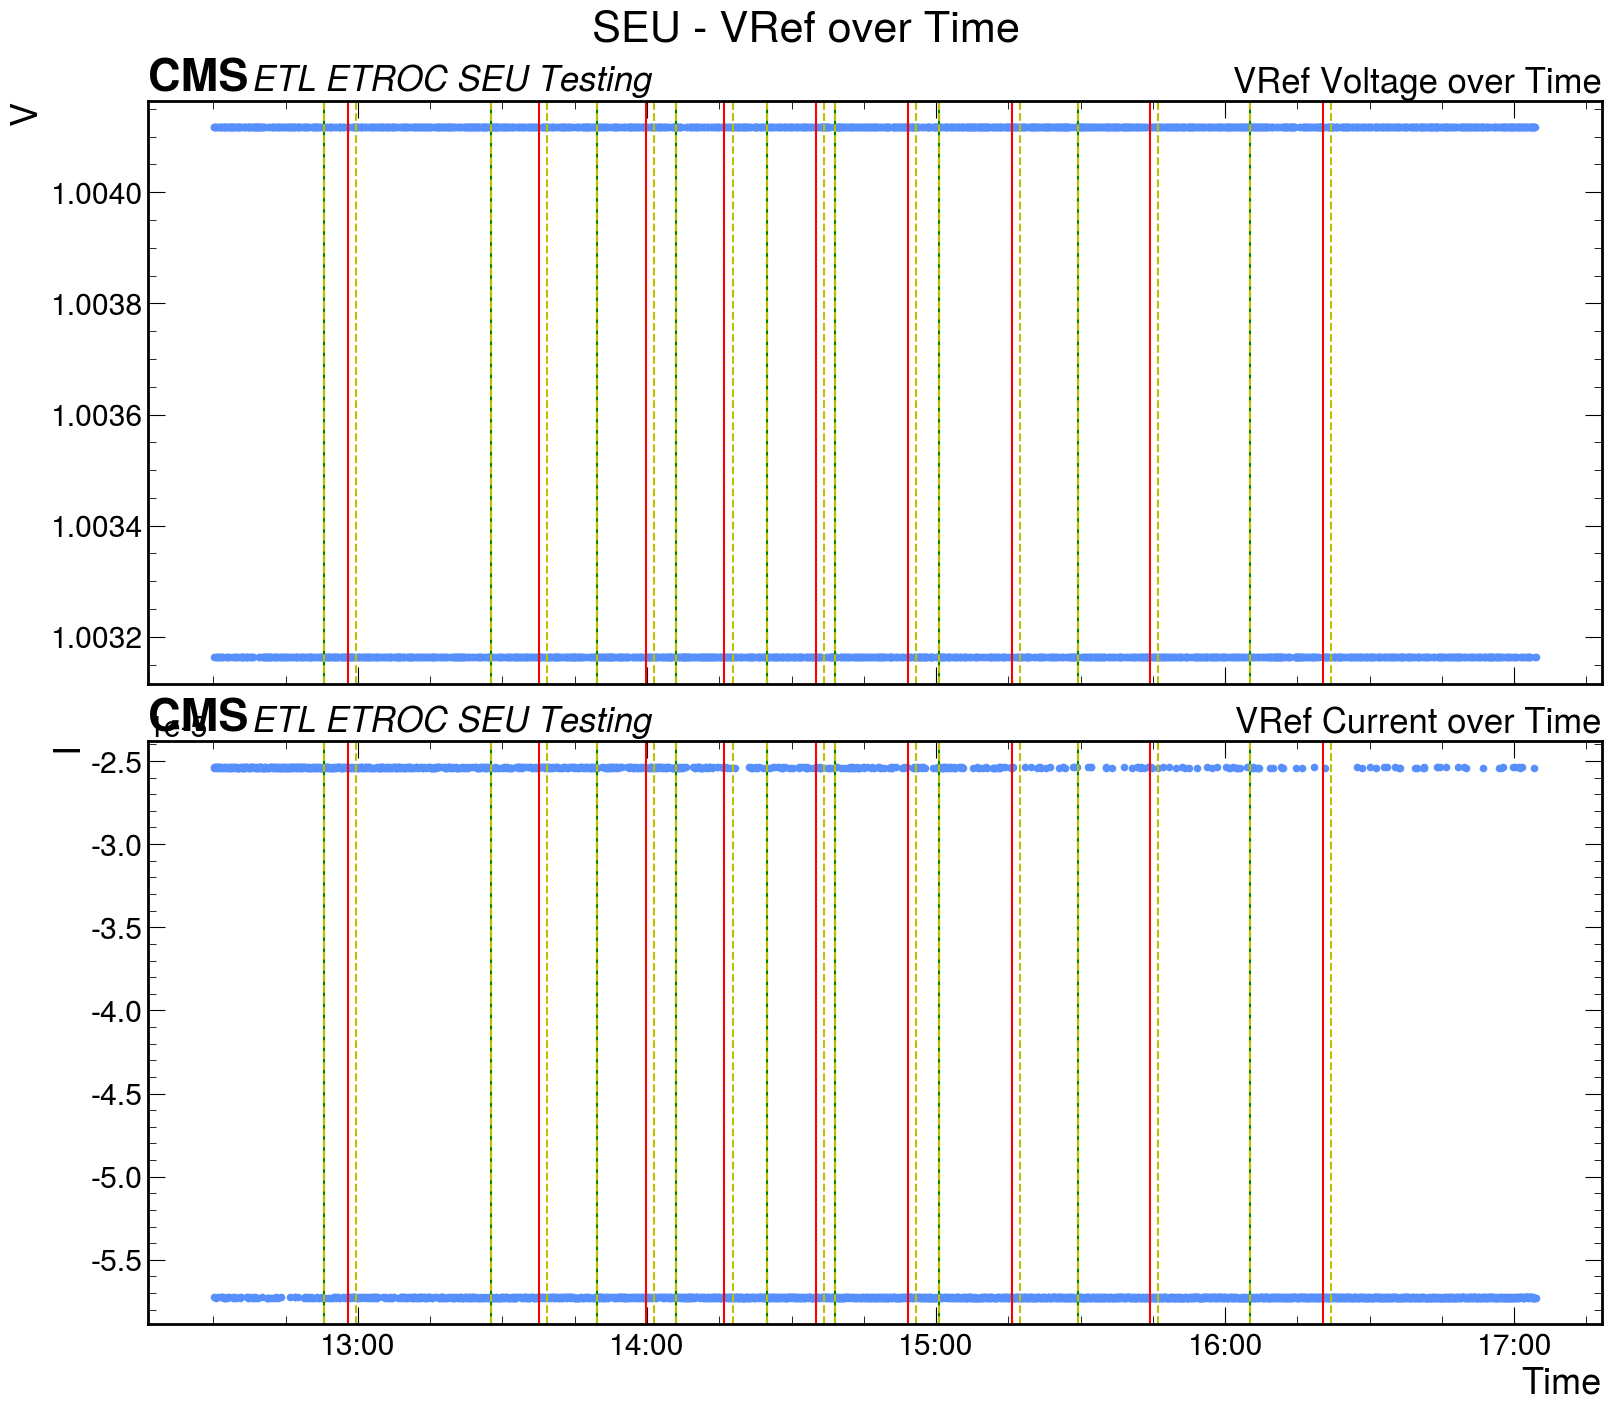

In [15]:
plotVRefPower(vref_df, 'SEU - VRef over Time', power_directory, True, run_info=run_info)

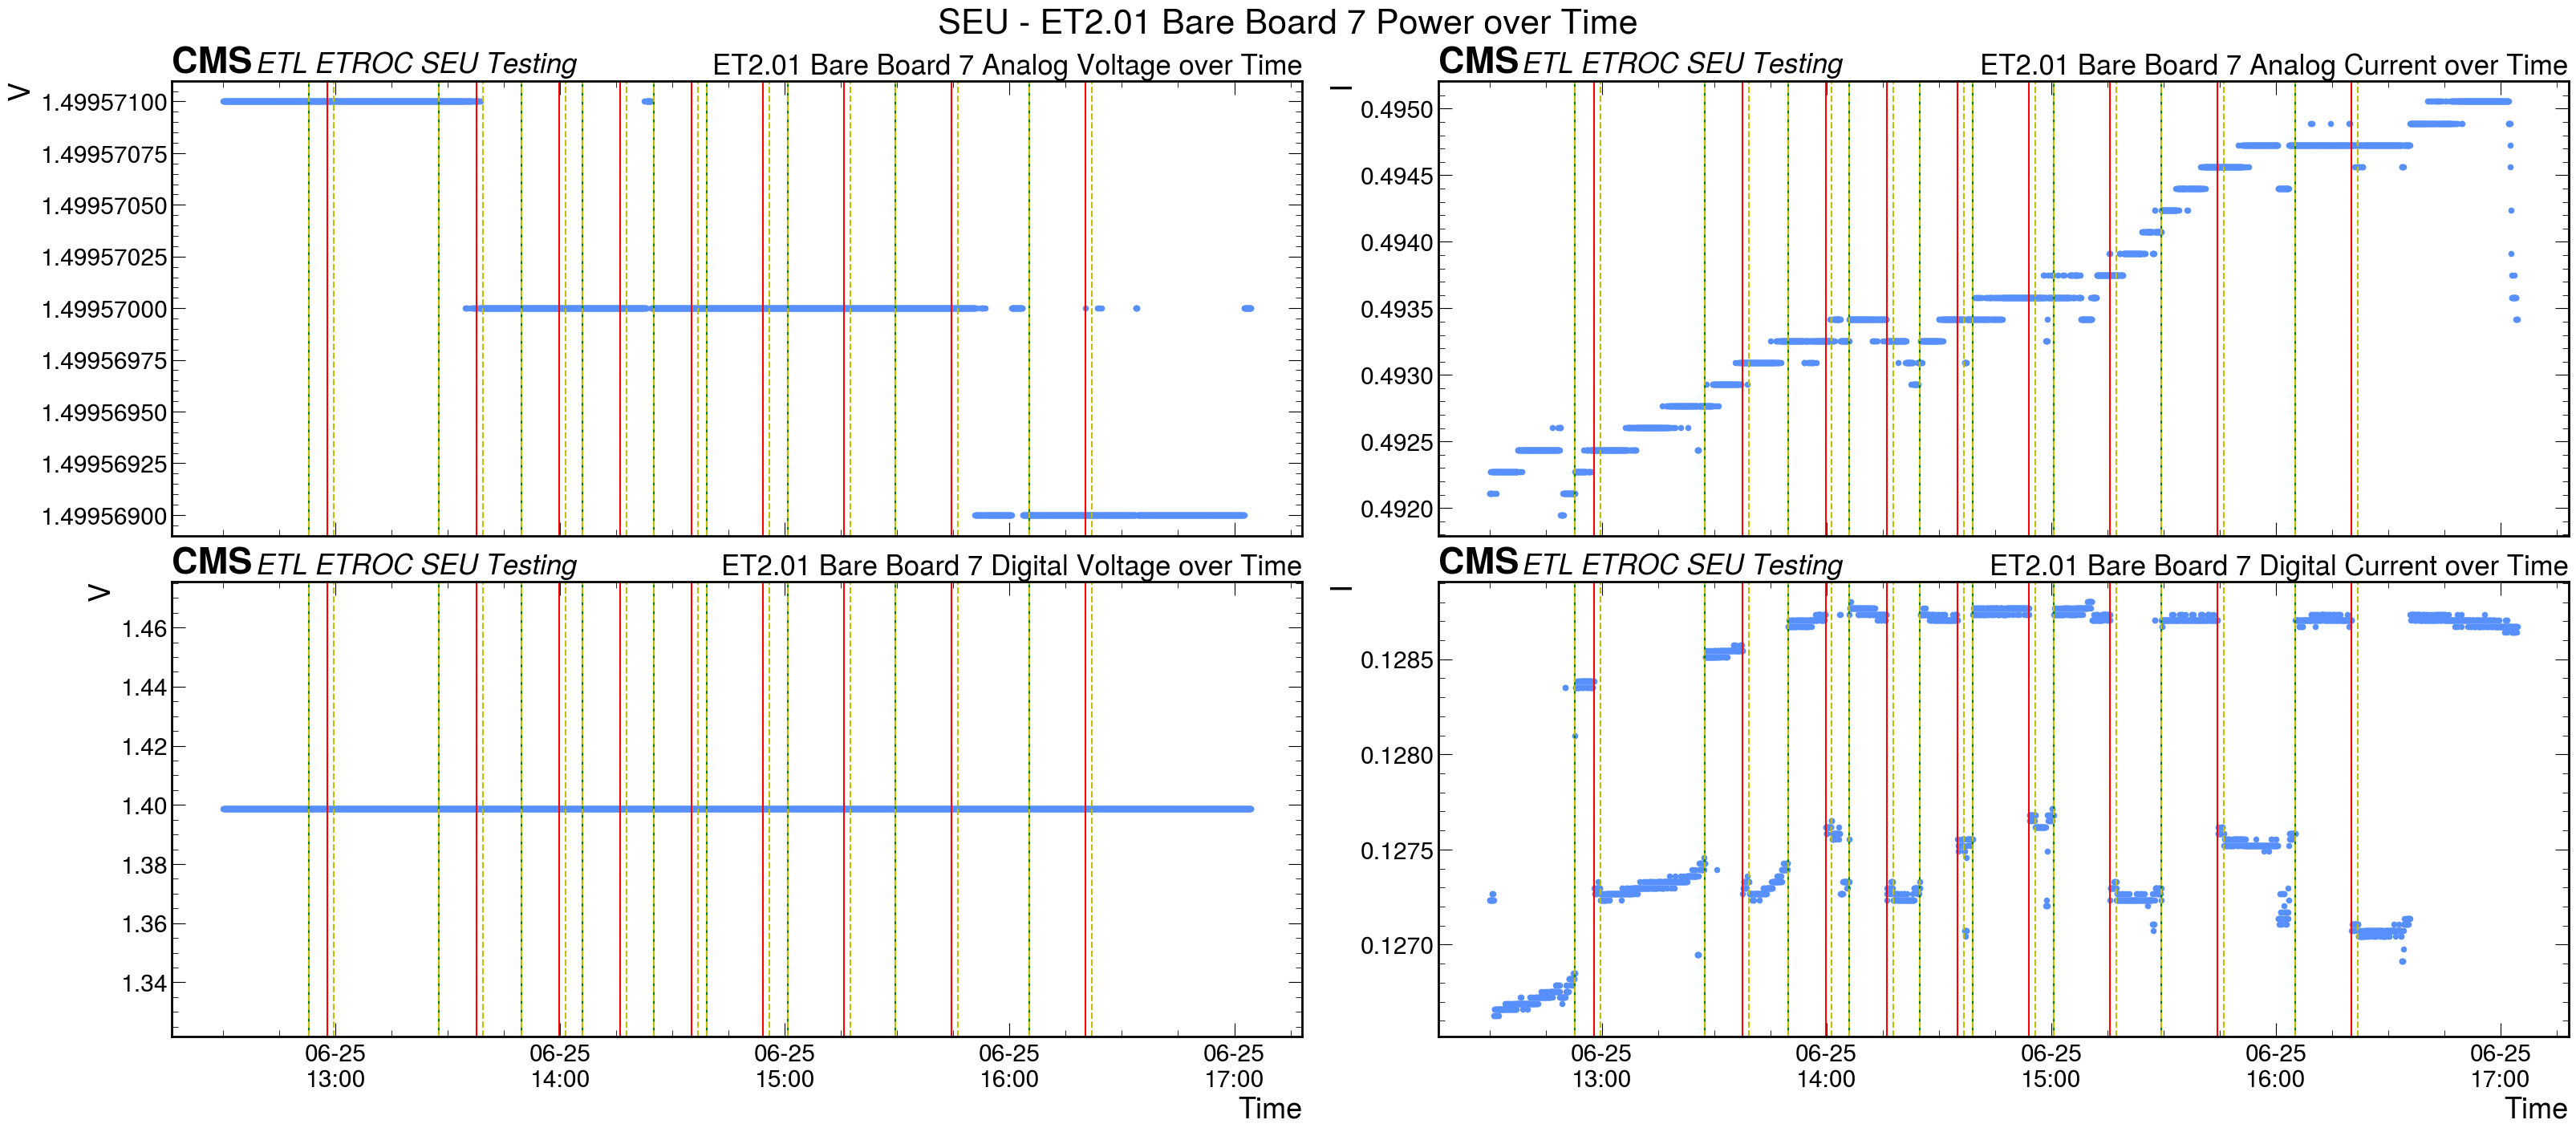

In [16]:
board = "ET2.01 Bare Board 7"
plotBoardPower(board, power_connections[board], data_df, f'SEU - {board} Power over Time', power_directory, True, run_info=run_info)

## Waveform Sampler

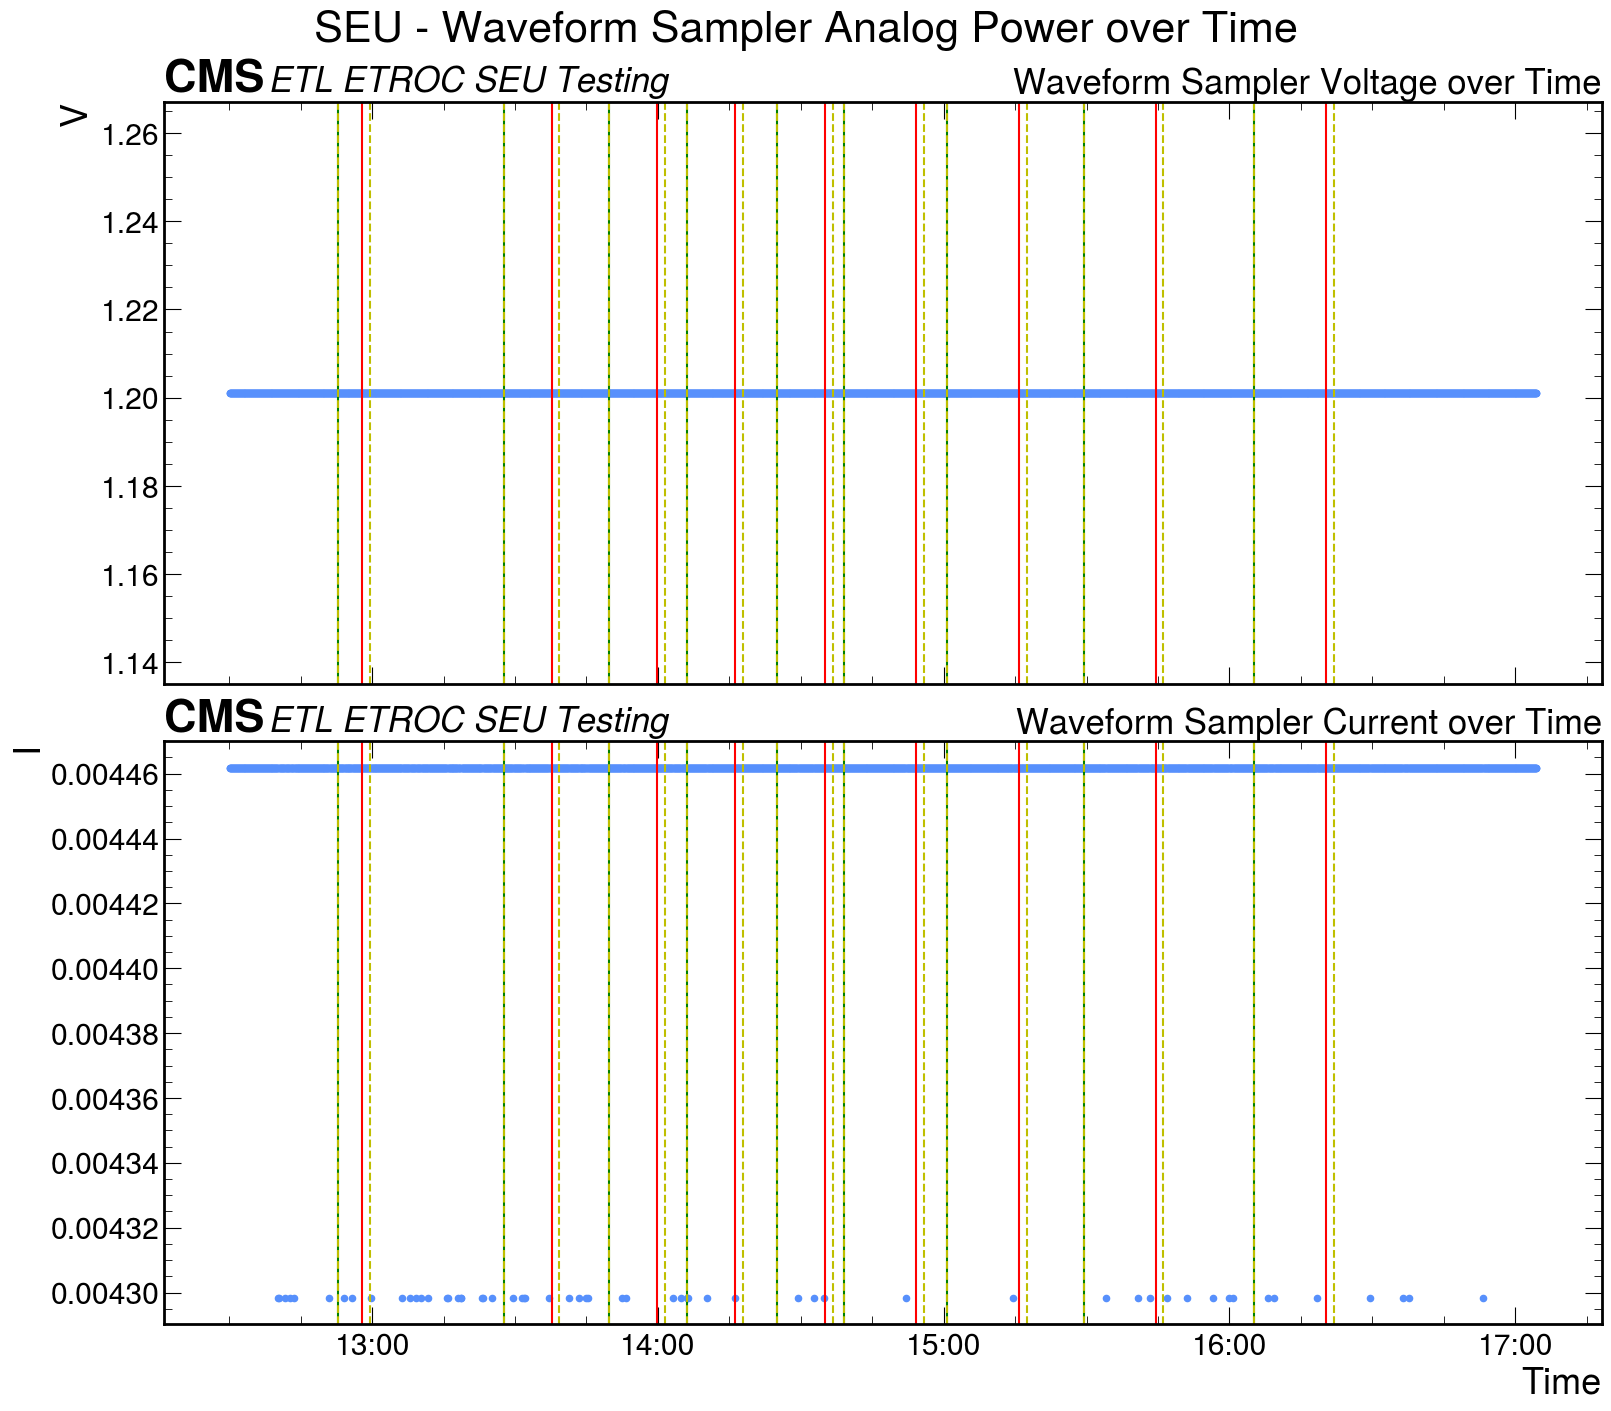

In [17]:
plotWSPower(wsana_df, 'SEU - Waveform Sampler Analog Power over Time', power_directory, True, run_info=run_info)

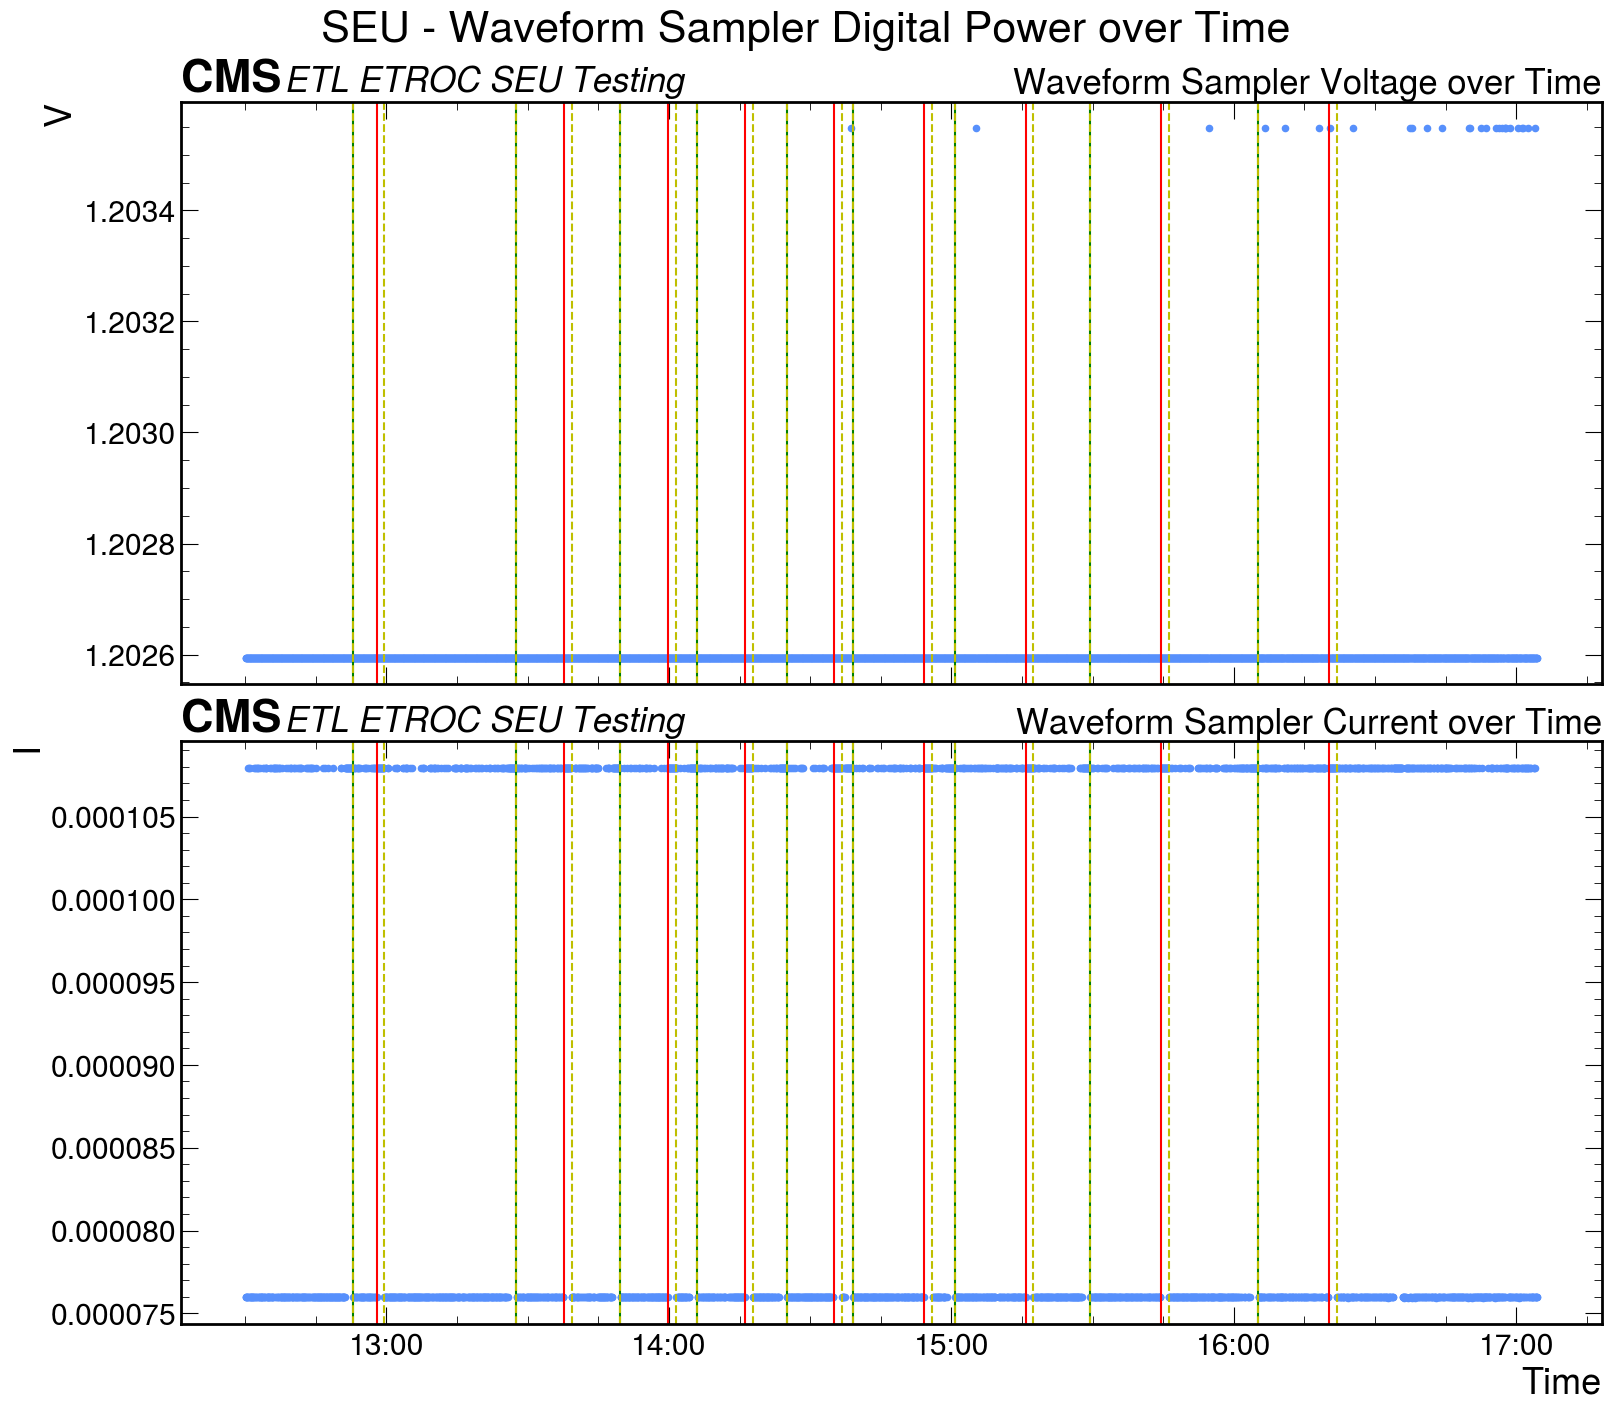

In [18]:
plotWSPower(wsdig_df, 'SEU - Waveform Sampler Digital Power over Time', power_directory, True, run_info=run_info)

## Per Run Plotting

In [19]:
# run_power_dir = power_directory/"PerRun"
# run_power_dir.mkdir(exist_ok=True)

# for run_idx_to_plot in range(len(run_info)):
#     if run_idx_to_plot == 0:
#         makePerRunPlots(
#             data_df,
#             run_info[run_idx_to_plot],
#             run_power_dir,
#             power_connections,
#             extra_run_info = None,
#             test_run_info = test_run_info,
#         )
#     else:
#         makePerRunPlots(
#             data_df,
#             run_info[run_idx_to_plot],
#             run_power_dir,
#             power_connections,
#             previous_run_info = run_info[run_idx_to_plot - 1],
#             extra_run_info = None,
#             test_run_info = test_run_info,
#         )

# # for this_run_info in extra_run_info:
# #     makePerRunPlots(
# #         data_df,
# #         this_run_info,
# #         run_power_dir,
# #         power_connections,
# #         all_run_info = run_info,
# #         extra_run_info = extra_run_info,
# #         test_run_info = test_run_info,
# #     )
